# Multilayer Perceptron

Loading the MNIST data set from `sklearn`.

In [1]:
from sklearn.datasets import load_digits

In [2]:
X, y = load_digits(return_X_y=True)

In [3]:
from sklearn.model_selection import train_test_split

Splitting into training and test data set.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

Transforming the labels into one-hot configuration

In [5]:
import numpy as np

In [6]:
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]

## Transforming to Tensors

In [7]:
import torch

In [8]:
X_train_torch    = torch.Tensor(X_train)
X_test_torch     = torch.Tensor(X_test)
y_train_oh_torch = torch.Tensor(y_train_oh)
y_test_oh_torch  = torch.Tensor(y_test_oh)

## Setting up Data Batches

In [9]:
from torch.utils.data import DataLoader

In [10]:
dataloader = {
    "train": DataLoader(list(zip(X_train_torch, y_train_oh_torch)), batch_size=10, shuffle=True),
    "test": DataLoader(list(zip(X_test_torch,  y_test_oh_torch)),  batch_size=len(y_test))
}

## Setting up the Network

In [11]:
class mlp(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(True),
            torch.nn.Linear(16, output_dim),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [12]:
model = mlp(X_train.shape[1], 10)
if torch.cuda.is_available():
    model.cuda()

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 100

## Training the Model

In [14]:
from tqdm.auto import tqdm

In [15]:
def fit(model, dataloader, optimizer, criterion, epochs):

    train_loss = []
    test_loss  = []

    for e in tqdm(range(epochs), desc="Epochs"):

        tr_loss = 0.
        te_loss = 0.

        model.train()
        for data, label in dataloader["train"]:
            if torch.cuda.is_available():
                data, label = data.cuda(), label.cuda()
            optimizer.zero_grad()
            target = model(data)
            loss = criterion(target, label)
            loss.backward()
            optimizer.step()
            tr_loss += loss.item()

        model.eval()
        for data, label in dataloader["test"]:
            if torch.cuda.is_available():
                data, label = data.cuda(), label.cuda()
            optimizer.zero_grad()
            target = model(data)
            loss = criterion(target, label)
            te_loss += loss.item()

        train_loss.append(tr_loss/len(dataloader["train"]))
        test_loss.append(te_loss/len(dataloader["test"]))
        
    loss = {
        "train": train_loss,
        "test": test_loss
    }
        
    return model, loss

In [16]:
model, loss = fit(model, dataloader, optimizer, criterion, epochs)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

## Loss Evaluation

In [17]:
import matplotlib.pyplot as plt

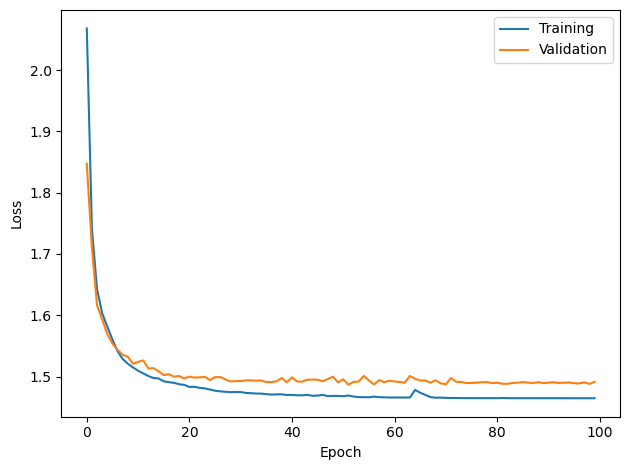

In [18]:
fig = plt.figure(dpi=100.)
ax = fig.add_subplot()
ax.plot(np.arange(epochs), loss["train"], label="Training")
ax.plot(np.arange(epochs), loss["test"], label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
fig.tight_layout()

## Predictions

In [19]:
def plot_prob(X, y, pred, i=None):
    width = 3.
    height = width/1.6
    if i is None:
        i = np.random.randint(0, len(X)-1)
    d = int(np.sqrt(X[0].shape[0]))
    fig = plt.figure(dpi=100, figsize=(3.*width, height))
    ax1 = plt.subplot2grid(shape=(1, 3), loc=(0, 0), colspan=1)
    ax2 = plt.subplot2grid(shape=(1, 3), loc=(0, 1), colspan=2)
    ax1.imshow(X[i, :].reshape((d, d)), cmap="Greys", vmax=X.max(), vmin=X.min())
    ax1.axis("off")
    ax1.set_title("Digit: {}".format(y[i]))
    ax2.bar(np.arange(10), pred[i, :]/pred[i, :].sum()*100)
    ax2.set_xlabel("Digit")
    ax2.set_ylabel("Probability")
    ax2.set_ylim(0., 100)
    ax2.grid(axis="y")
    ax2.set_xticks(np.arange(10))
    ax2.set_title("Prediction: {}".format(pred[i].argmax()))
    ax2.set_yticks(ax2.get_yticks())
    ax2.set_yticklabels(["{:3.0f}%".format(p) for p in ax2.get_yticks()])
    fig.tight_layout()

In [20]:
pred_train = model(X_train_torch).detach().numpy()
pred_test  = model(X_test_torch).detach().numpy()

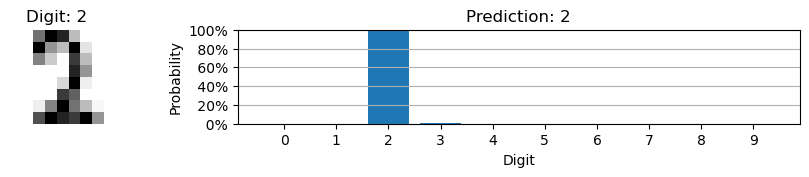

In [21]:
plot_prob(X_test, y_test, pred_test)

### Checking the failures

In [22]:
mask_fail = y_test != pred_test.argmax(1)

In [23]:
msg = "Total number of false identifications: {}".format(mask_fail.sum())
print(msg)

Total number of false identifications: 5


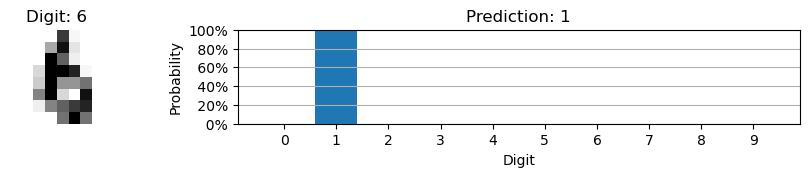

In [24]:
plot_prob(X_test[mask_fail], y_test[mask_fail], pred_test[mask_fail])

## Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
cmat_test = confusion_matrix(y_test, pred_test.argmax(1), normalize="pred")

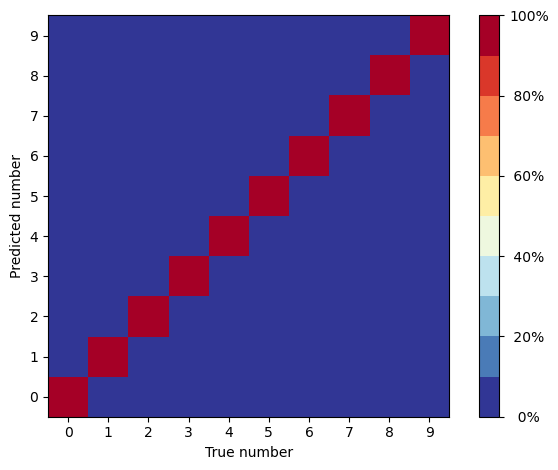

In [27]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
cmap = plt.get_cmap("RdYlBu_r", 10)
plot = ax.imshow(cmat_test*100, cmap=cmap, vmin=0, vmax=100)
cbar = plt.colorbar(plot, ax=ax)
cbar.ax.set_yticks(cbar.ax.get_yticks())
cbar.ax.set_yticklabels(["{:3.0f}%".format(proc) for proc in cbar.ax.get_yticks()])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("True number")
ax.set_ylabel("Predicted number")
fig.tight_layout()

## Accuracy

In [28]:
acc_train = (y_train == pred_train.argmax(1)).sum()/len(y_train)
acc_test = (y_test == pred_test.argmax(1)).sum()/len(y_test)

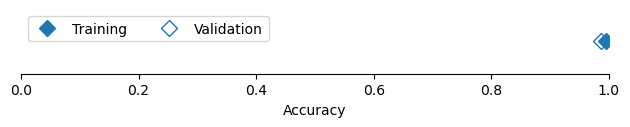

In [29]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, aspect=1)
ax.plot(acc_train, 0, "D", markersize=8, fillstyle="full", c="C0", label="Training")
ax.plot(acc_test, 0, "D", markersize=8, fillstyle="none", c="C0", label="Validation")
ax.set_xlim(0., 1)
ax.set_xlabel("Accuracy")
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks([])
ax.legend(loc="upper left", ncol=2)
fig.tight_layout()